In [1]:
import pickle
import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    r2_score,
)

# Helper functions

In [2]:
from tensorflow import one_hot
from tensorflow.python.keras.layers import Concatenate

GLM_HMM_SIMULUS_VALUES = [
    -1,
    -0.5,
    -0.25,
    -0.125,
    -0.0625,
    0,
    0.0625,
    0.125,
    0.25,
    0.5,
    1,
]
LASENET_KEY = "LaseNet"


def get_onehot_features(data, input_list):
    n_agent = len(data["agentid"].unique())
    n_trial = len(data["trials"].unique())
    features = []
    for key in input_list:
        input = data[key].to_numpy()
        unique_input = GLM_HMM_SIMULUS_VALUES if key == "stim" else np.unique(input)

        cat_map = {item: i for i, item in enumerate(unique_input)}
        input_cat = [cat_map[s] for s in input]
        input_cat = np.array(input_cat).astype(np.int32).reshape((n_agent, n_trial))
        features.append(one_hot(input_cat, len(unique_input)))

    return Concatenate(axis=2)(features)


def lasenet_predict(test_data, model_path, feature_list):
    test_features = get_onehot_features(test_data, feature_list)

    # evaluate LaseNet
    best_model = tf.keras.models.load_model(model_path)
    output_tokens = best_model.predict(test_features)
    return output_tokens


def _get_bin_accuracy(y_pred, is_correct, num_bins=5):
    bin_edges = np.linspace(
        0, 1, num_bins + 1
    )  # Create evenly spaced bin edges between 0 and 1
    # Bin the probability values
    bin_indices = np.digitize(y_pred, bin_edges)
    all_acc, all_bins = [], []
    for i in range(1, num_bins + 1):
        locs = np.where(bin_indices == i)[0]
        if len(locs) == 0:
            continue

        acc = round(sum(is_correct[locs]) / len(locs), 3)
        bin_mid = np.mean(bin_edges[i - 1 : i + 1])
        all_bins.append(round(bin_mid, 2))
        all_acc.append(acc)

    return all_acc, all_bins


def _plot_choice_data(choices, was_correct, title, title_size, i):
    # plot choice, color by correct/incorrect:
    this_y = choices + np.random.normal(0, 0.03, len(choices))

    locs_correct = np.where(was_correct == 1)[0]
    locs_incorrect = np.where(was_correct == 0)[0]
    plt.plot(
        locs_correct,
        this_y[locs_correct],
        "o",
        color="black",
        markersize=4,
        zorder=3,
        alpha=0.5,
    )
    plt.plot(
        locs_incorrect,
        this_y[locs_incorrect],
        "v",
        color="red",
        markersize=4,
        zorder=4,
        alpha=0.5,
    )

    plt.ylim((-0.13, 1.13))
    plt.yticks([0, 1], ["L", "R"])
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(3)
    # increase tick width
    plt.gca().tick_params(width=4)
    plt.title(title, fontsize=title_size)

    if i == 0:
        plt.ylabel("choice")
        plt.annotate("Incorrect", xy=(2, 0.4), color="red", fontsize=10)
        plt.annotate("Correct", xy=(2, 0.6), color="black", fontsize=10)


def _configure_ticks(ax, i, y_title, title_size=12):
    if i == 0:
        ax.set_ylabel(y_title, fontsize=title_size)

    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
    # increase tick width
    ax.tick_params(width=4)
    return ax


def plot_regression(ax, color, y_true, y_pred, benchmark):
    result = pd.DataFrame({LASENET_KEY: y_pred, benchmark: y_true})
    ax = sns.regplot(
        data=result,
        x=LASENET_KEY,
        ci=99,
        scatter_kws={"s": 8, "alpha": 0.5},
        y=benchmark,
        color=color,
        line_kws=dict(color="#f73e40"),
        ax=ax,
    )

    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.1,
        0.95,
        "$R^2$ = {:.3f}".format(r2),
        horizontalalignment="left",
        verticalalignment="center",
        color="black",
        fontweight="heavy",
        transform=ax.transAxes,
        size=9,
    )

    corr = np.corrcoef(y_true, y_pred)[0, 1]
    ax.text(
        0.1,
        0.8,
        "$r$ = {:.3f}".format(corr),
        horizontalalignment="left",
        verticalalignment="center",
        color="black",
        transform=ax.transAxes,
        size=9,
    )
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
    # increase tick width
    ax.tick_params(width=4)
    return ax

# Dynamic foraging dataset - Meta RL

In [3]:
sub_dir = "dynamic_foraging"

num_bandits = 2
feature_list = ["actions", "rewards"]
target_names = ["random", "engaged"]
# Load the mice raw data
df_data = pd.read_csv("data/mice_46a_300t_dynamic_foraging.csv")
num_agents = len(df_data["agentid"].unique())
n_trial = len(df_data["trials"].unique())

rewards = df_data["rewards"].to_numpy().astype(np.int64).reshape((num_agents, n_trial))
actions = df_data["actions"].to_numpy().astype(np.int64).reshape((num_agents, n_trial))

# Load MLE results
mice_mle_parameters = pd.read_csv(
    "mle/mice_jj_46a_dynamic_foraging_parameters.csv"
)  # data_dir mle_parameters_mice_46a_300t_dynamic_foraging.csv
mle_pred_state_prob = pd.read_csv(
    "mle/jj_latent_mice_46a_300t_dynamic_foraging.csv"
).to_numpy()
mle_pred_left_q = pd.read_csv(
    "mle/jj_leftQ_mice_46a_300t_dynamic_foraging.csv"
).to_numpy()
mle_pred_right_q = pd.read_csv(
    "mle/jj_rightQ_mice_46a_300t_dynamic_foraging.csv"
).to_numpy()
mle_q_diff = mle_pred_right_q - mle_pred_left_q

# Estimate with pretrained LaseNet on Meta RL model
model_name = "../results/models/metarl_pretrained"
lasenet_pred_state_prob, lasenet_pred_left_q, lasenet_pred_right_q = lasenet_predict(
    df_data, model_name, feature_list
)
lasenet_pred_left_q = lasenet_pred_left_q.reshape(num_agents, n_trial)
lasenet_pred_right_q = lasenet_pred_right_q.reshape(num_agents, n_trial)
lasenet_q_diff = lasenet_pred_right_q - lasenet_pred_left_q

2/2 [==============================] - 1s 38ms/step


## Plot the time series data

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

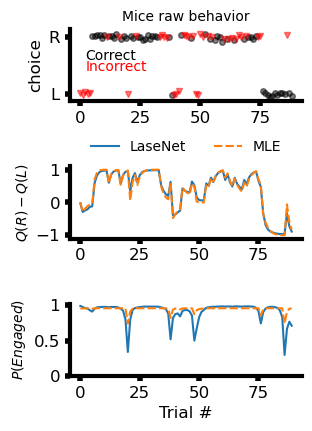

In [4]:
plt.rcParams.update({"font.size": 12})
max_trial = 90
nrows, ncols = 3, 1
mice_id = 0

fig = plt.figure(figsize=(ncols * 3, nrows * 1.5))
plt.subplots_adjust(wspace=0.2, hspace=0.9)

ax = plt.subplot(nrows, ncols, 1)
# agent index starts from 1 so increase mice_id by 1.
subj = df_data[(df_data["agentid"] == mice_id + 1) & (df_data.trials < max_trial)]
choice = subj["actions"].to_numpy()
was_correct = subj["rewards"].to_numpy()

_plot_choice_data(choice, was_correct, "Mice raw behavior", 10, 0)

ax = plt.subplot(nrows, ncols, 2)
result = {
    LASENET_KEY: lasenet_q_diff[mice_id][:max_trial],
    "MLE": mle_q_diff[mice_id][:max_trial],
}
# Show the q
plot_ = sns.lineplot(result, ax=ax, legend=True)
_configure_ticks(ax, mice_id, r"$Q(R)-Q(L)$", 10)
sns.move_legend(
    ax,
    "lower center",
    fontsize=10,
    bbox_to_anchor=(0.5, 1),
    ncol=len(result),
    title=None,
    frameon=False,
)

ax = plt.subplot(nrows, ncols, 3)  # i+5)
result = {
    LASENET_KEY: lasenet_pred_state_prob[mice_id][:max_trial][:, 1],
    "MLE": mle_pred_state_prob[mice_id][:max_trial],
}
# Show the engaged prob
plot_ = sns.lineplot(result, ax=ax, legend=False)
_configure_ticks(ax, 0, "$P(Engaged)$", 10)

ax.set(yticks=[0, 0.5, 1], yticklabels=[0, 0.5, 1])
ax.set_xlabel("Trial #")

sns.despine()

## Plot psychometrics

In [5]:
# @title bin choice and accruacy probability
def _get_bin_probability_right(
    pred_q_diff, pred_latent, is_right, target_state, num_bins=5
):
    bin_edges = np.linspace(
        -1, 1, num_bins + 1
    )  # Create evenly spaced bin edges between -1 and 1
    # Bin the probability values
    bin_indices = np.digitize(pred_q_diff, bin_edges)
    target_state_locs = np.where(pred_latent == target_state)[
        0
    ]  # find_repeated_states_indexes(pred_latent, target_state, 3) #
    all_prob_right, all_bins = [], []
    for i in range(1, num_bins + 1):
        locs = np.where(bin_indices == i)[0]
        # print('before: ', len(locs), locs)
        # only do engaged state
        intersection = np.intersect1d(locs, target_state_locs)
        if len(intersection) == 0:
            continue
        # print('engaged: ',len(intersection), intersection)
        prob = round(sum(is_right[intersection]) / len(intersection), 3)
        bin_mid = np.mean(bin_edges[i - 1 : i + 1])
        all_bins.append(round(bin_mid, 2))
        all_prob_right.append(prob)

    return all_prob_right, all_bins


threshold = 0.5
ann_pred_latent = (lasenet_pred_state_prob[:, :, 1] > threshold).astype(int)
mle_pred_latent = (mle_pred_state_prob > threshold).astype(int)

num_bins = 5
pr_result = {"p_r": [], "agent": [], "bin_edge": [], "estimator": [], "state": []}
for m, (q_diff, state) in zip(
    [LASENET_KEY, "MLE"],
    [(lasenet_q_diff, ann_pred_latent), (mle_q_diff, mle_pred_latent)],
):
    for a in range(len(q_diff)):
        for si, sn in enumerate(target_names):
            pr, bins = _get_bin_probability_right(
                q_diff[a], state[a], actions[a], si, num_bins
            )
            pr_result["p_r"].extend(pr)
            pr_result["bin_edge"].extend(bins)
            pr_result["agent"].extend([a] * len(pr))
            pr_result["estimator"].extend([m] * len(pr))
            pr_result["state"].extend([sn] * len(pr))

pr_result = pd.DataFrame(pr_result)

num_bins = 5
acc_result = {"accuracy": [], "agent": [], "bin_edge": [], "estimator": []}
for m, pred_prob in zip(
    [LASENET_KEY, "MLE"], [lasenet_pred_state_prob[:, :, 1], mle_pred_state_prob]
):
    for a, y_pred in enumerate(pred_prob):
        acc, bins = _get_bin_accuracy(y_pred, rewards[a], num_bins)
        acc_result["accuracy"].extend(acc)
        acc_result["bin_edge"].extend(bins)
        acc_result["agent"].extend([a] * len(acc))
        acc_result["estimator"].extend([m] * len(acc))

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore

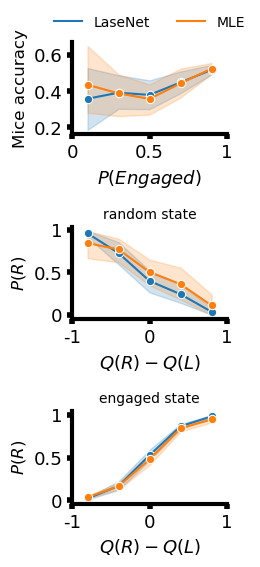

In [6]:
plt.rcParams.update({"font.size": 13})

nrows, ncols = 3, 1
fig = plt.figure(figsize=(ncols * 2, nrows * 2))
plt.subplots_adjust(wspace=0.4, hspace=1)

ax = plt.subplot(nrows, ncols, 1)
b = sns.lineplot(
    acc_result,
    x="bin_edge",
    y="accuracy",
    marker="o",
    hue="estimator",
    ax=ax,
    legend=True,
)
b.set_xlabel("$P(Engaged)$")
xticks = [0, 0.5, 1]
yticks = [0.2, 0.4, 0.6]
b.set(xticks=xticks, xticklabels=xticks, yticks=yticks, yticklabels=yticks)
_configure_ticks(b, 0, "Mice accuracy", 12)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    title=None,
    frameon=False,
    fontsize=10,
)
sns.despine()

for i, t in enumerate(target_names):
    ax = plt.subplot(nrows, ncols, i + 2)
    b = sns.lineplot(
        pr_result[pr_result.state == t],
        x="bin_edge",
        y="p_r",
        marker="o",
        hue="estimator",
        ax=ax,
        legend=False,
    )
    b.set_xlabel(r"$Q(R)-Q(L)$")
    yticks = [0, 0.5, 1]
    b.set(xticks=[-1, 0, 1], xticklabels=[-1, 0, 1], yticks=yticks, yticklabels=yticks)
    _configure_ticks(b, 0, r"$P(R)$", 12)
    b.set_title(t + " state", size=10)

    sns.despine()

## Regression MLE vs LaseNet

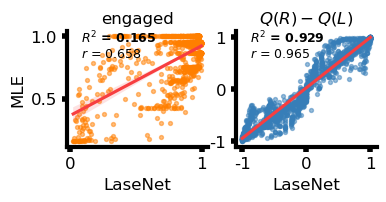

In [7]:
plt.rcParams.update({"font.size": 12})

nrows, ncols = 1, 2
fig = plt.figure(figsize=(ncols * 2, nrows * 1.5))

state_color = ["#4daf4a", "#ff7f00", "#377eb8"]
num_sample = 5

lasenet_pred = lasenet_pred_state_prob[:num_sample, :, 1].ravel()
mle_pred = mle_pred_state_prob[:num_sample, :].ravel()
ax = plt.subplot(nrows, ncols, ncols - 1)
plot_regression(ax, state_color[1], mle_pred, lasenet_pred, "MLE")
ax.set_title("engaged", fontsize=12)

ax = plt.subplot(nrows, ncols, ncols)
lasenet_pred = mle_q_diff[:num_sample].ravel()
mle_pred = lasenet_q_diff[:num_sample].ravel()
plot_regression(ax, state_color[2], mle_pred, lasenet_pred, "MLE")
ax.set_title(r"$Q(R)-Q(L)$", fontsize=12)
ax.set(xticks=[-1, 0, 1], xticklabels=[-1, 0, 1])
ax.set(yticks=[-1, 0, 1], yticklabels=[-1, 0, 1])
ax.set_ylabel("")
sns.despine()

# IBL dataset - GLM-HMM

In [8]:
sub_dir = "glmhmm"

num_bandits = 2
feature_list = ["stim", "actions", "wsls"]
target_names = ["engaged", "biased-left", "biased-right"]
state_color = ["#ff7f00", "#4daf4a", "#377eb8"]

# Load IBL data
ibl_data = pd.read_csv("data/example_mouse_3a_ibl.csv")
# Exclude sessions that have missing data.
excluded_session = ibl_data["agentid"].unique()[25]
all_sessions = list(ibl_data["agentid"].unique())
max_trial = 90
filtered_data = ibl_data[
    (ibl_data["trials"] < max_trial) & (ibl_data["agentid"] != excluded_session)
]

# load EM result
with open("em/v3CSHL_008_fitting_glmhmm.pkl", "rb") as fp:
    em_results = pickle.load(fp)
em_pred_state = em_results["posterior_probs"]

# Estimate with LaseNet
model_name = "../results/models/glmhmm_pretrained"
lasenet_pred_state = lasenet_predict(filtered_data, model_name, feature_list)

3/3 [==============================] - 0s 20ms/step


In [9]:
def get_was_correct(this_inpt, this_y):
    """
    return a vector of size this_y.shape[0] indicating if
    choice was correct on current trial.  Return NA if trial was not "easy"
    trial
    :param this_inpt:
    :param this_y:
    :return:
    """
    was_correct = np.empty(this_y.shape[0])
    was_correct[:] = np.NaN
    idx_easy = np.where(np.abs(this_inpt) > 0.002)[0]
    correct_side = (np.sign(this_inpt[idx_easy]) + 1) / 2
    was_correct[idx_easy] = (correct_side == this_y[idx_easy]) + 0
    return was_correct, idx_easy


def _get_state_prob(y_pred, session_idx, max_trial, target_names):
    probs, names = [], []
    for tidx, name in enumerate(target_names):
        probs.extend(y_pred[session_idx][:, tidx])
        names.extend([name] * max_trial)

    return pd.DataFrame(
        {
            "probs": probs,
            "names": names,
            "trials": np.tile(np.arange(max_trial), len(target_names)),
        }
    )

## Plot time series data for one session

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore

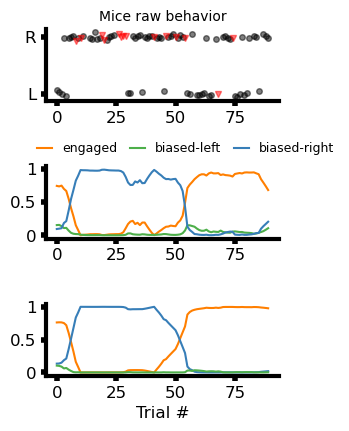

In [13]:
# @title Plot all the time series data
sess_to_plot = [
    "CSHL_008-2019-04-29-001-alf",
]
mice_id= sess_to_plot[0]
session_list = filtered_data["agentid"].unique()

nrows, ncols = 3, 1
fig = plt.figure(figsize=(ncols * 3, nrows * 1.5))
plt.subplots_adjust(wspace=0.2, hspace=0.9)

# Plot choice data
ax = plt.subplot(nrows, ncols, 1)
mouse = filtered_data[filtered_data["agentid"] == mice_id]
choice = mouse["actions"].to_numpy()
was_correct, idx_easy = get_was_correct(mouse["stim"].to_numpy(), choice)
_plot_choice_data(choice, was_correct, "Mice raw behavior", 10, i)

# LaseNet result
session_idx = np.where(session_list == mice_id)[0][0]
ax = plt.subplot(nrows, ncols, 2)
result = _get_state_prob(lasenet_pred_state, session_idx, max_trial, target_names)
ax = sns.lineplot(
    result, x="trials", y="probs", hue="names", palette=state_color, legend=True, ax=ax
)
ax.set_ylabel("")
ax.set_xlabel("")
_configure_ticks(ax, i, f"{LASENET_KEY}\n" + r"$P(state)$", 10)
ax.set(yticks=[0, 0.5, 1], yticklabels=[0, 0.5, 1])
sns.move_legend(
    ax,
    "lower center",
    fontsize=9,
    columnspacing=1,
    handlelength=1.2,
    bbox_to_anchor=(0.6, 1),
    ncol=3,
    title=None,
    frameon=False,
)

# EM results
ax = plt.subplot(nrows, ncols, 3)
result = _get_state_prob(em_pred_state, session_idx, max_trial, target_names)
ax = sns.lineplot(
    result,
    x="trials",
    y="probs",
    hue="names",
    palette=["#ff7f00", "#377eb8", "#4daf4a"],
    legend=False,
    ax=ax,
)
ax.set_ylabel("")
_configure_ticks(ax, i, "EM\n" + r"$P(state)$", 10)
ax.set(yticks=[0, 0.5, 1], yticklabels=[0, 0.5, 1])
ax.set_xlabel("Trial #")

sns.despine()

## Plot psychometrics

In [14]:
# @title bin state accuracy
def _get_choice_probaility_for_state(ann_outcomes, em_res_prob, actions, num_bins):
    ibt_result = {"bin_edge": [], "prob": [], "agent": [], "estimator": []}
    for m, pred_prob in zip([LASENET_KEY, "EM"], [ann_outcomes, em_res_prob]):
        for a, y_pred in enumerate(pred_prob):
            prob, bins = _get_bin_accuracy(y_pred, actions[a], num_bins)
            ibt_result["prob"].extend(prob)
            ibt_result["bin_edge"].extend(bins)
            ibt_result["agent"].extend([a] * len(prob))
            ibt_result["estimator"].extend([m] * len(prob))
    return ibt_result


plt.rcParams.update({"font.size": 14})

num_bins = 4
num_sessions = len(filtered_data.agentid.unique())
n_trial = len(filtered_data.trials.unique())
rewarded = (
    filtered_data["rewarded"]
    .to_numpy()
    .astype(np.int64)
    .reshape((num_sessions, n_trial))
)
rewarded[rewarded == -1] = 0

em_res_prob = np.array(em_pred_state)
acc_result = {"bin_edge": [], "accuracy": [], "agent": [], "estimator": []}
for m, pred_prob in zip([LASENET_KEY, "EM"], [lasenet_pred_state[:, :, 0], em_res_prob[:, :, 0]]):
    for a, y_pred in enumerate(pred_prob):
        acc, bins = _get_bin_accuracy(y_pred, rewarded[a], num_bins)
        acc_result["accuracy"].extend(acc)
        acc_result["bin_edge"].extend(bins)
        acc_result["agent"].extend([a] * len(acc))
        acc_result["estimator"].extend([m] * len(acc))


num_sessions = len(filtered_data.agentid.unique())
n_trial = len(filtered_data.trials.unique())
actions = (
    filtered_data["actions"]
    .to_numpy()
    .astype(np.int64)
    .reshape((num_sessions, n_trial))
)
em_res_prob = np.array(em_res_prob)

choice_results = {}
for idx, state in enumerate(["Left-biased", "Right-biased"]):
    if state == "Left-biased":
        ann, em = lasenet_pred_state[:, :, 1], em_res_prob[:, :, 2]
    else:
        ann, em = lasenet_pred_state[:, :, 2], em_res_prob[:, :, 1]

    choice_results[state] = _get_choice_probaility_for_state(ann, em, actions, num_bins) 

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore

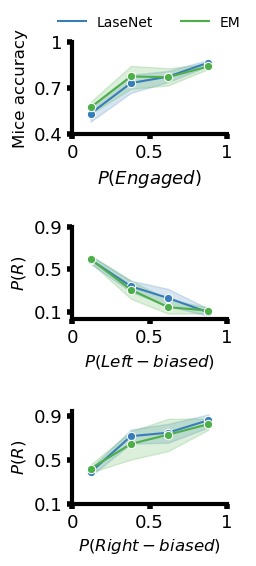

In [15]:
plt.rcParams.update({"font.size": 13})
nrows, ncols = 3, 1
fig = plt.figure(figsize=(ncols * 2, nrows * 2))
plt.subplots_adjust(wspace=0.4, hspace=1)
# plot accuracy
ax = plt.subplot(nrows, ncols, 1)
b = sns.lineplot(
    acc_result,
    x="bin_edge",
    y="accuracy",
    marker="o",
    hue="estimator",
    ax=ax,
    palette=["#377eb8", "#4daf4a"],
)
b.set_xlabel("$P(Engaged)$")
xticks = [0, 0.5, 1]
yticks = [0.4, 0.7, 1]
b.set(xticks=xticks, xticklabels=xticks, yticks=yticks, yticklabels=yticks)
_configure_ticks(b, 0, "Mice accuracy", 12)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    title=None,
    frameon=False,
    fontsize=10,
)
sns.despine()

# plot choice
idx = 0
for st, res in choice_results.items():
    ax = plt.subplot(nrows, ncols, idx + 2)
    b = sns.lineplot(
        res,
        x="bin_edge",
        y="prob",
        marker="o",
        hue="estimator",
        ax=ax,
        palette=["#377eb8", "#4daf4a"],
        legend=False,
    )

    b.set_xlabel(f"$P({st})$", size=12)

    xticks = [0, 0.5, 1]
    yticks = [0.1, 0.5, 0.9]
    b.set(xticks=xticks, xticklabels=xticks, yticks=yticks, yticklabels=yticks)

    ytitle = r"$P(R)$"
    _configure_ticks(b, 0, ytitle, 12)
    sns.despine()
    idx = idx + 1

## Regression EM vs LaseNet

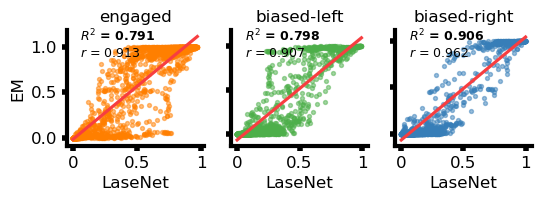

In [16]:
em_score = np.array(em_pred_state)
em_ann_state_map = {0: 0, 1: 2, 2: 1}
num_session = int(lasenet_pred_state.shape[0] / 3)

plt.rcParams.update({"font.size": 12})
nrows, ncols = 1, len(target_names)
fig = plt.figure(figsize=(ncols * 2, nrows * 1.5))

for idx, pn in enumerate(target_names):
    ann_pred = lasenet_pred_state[:num_session, :, idx].ravel()
    em_pred = em_score[:num_session, :, em_ann_state_map[idx]].ravel()

    ax = plt.subplot(nrows, ncols, idx + 1)
    plot_regression(ax, state_color[idx], em_pred, ann_pred, "EM")
    if idx > 0:
        ax.set_ylabel("")
        ax.set(yticks=[0, 0.5, 1], yticklabels=[])

    ax.set(xticks=[0, 0.5, 1], xticklabels=[0, 0.5, 1])
    ax.set_title(pn, fontsize=12)
    sns.despine()